In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

places = [
    {"name": "Ha Long Bay", "type": "adventure"}, #0.45 
    {"name": "Hoi An", "type": "culture"}, # 0.6
    {"name": "Phu Quoc", "type": "relaxation"},
    {"name": "Hue", "type": "culture"},
    {"name": "Da Lat", "type": "relaxation"},
    {"name": "Sapa", "type": "adventure"},
    {"name": "Hanoi", "type": "culture"},
    {"name": "Nha Trang", "type": "food"},
]

place_types = list(set(p["type"] for p in places))

user_profiles = [
    {"id": 0, "prefs": {"adventure": 0.8, "culture": 0.1, "relaxation": 0.05, "food": 0.05}},
    {"id": 1, "prefs": {"adventure": 0.2, "culture": 0.6, "relaxation": 0.1, "food": 0.1}},
    {"id": 2, "prefs": {"adventure": 0.1, "culture": 0.1, "relaxation": 0.7, "food": 0.1}},
    {"id": 3, "prefs": {"adventure": 0.2, "culture": 0.2, "relaxation": 0.2, "food": 0.4}},
]

In [2]:
def simulate_reward(user, place):
    """
    Reward = 1 nếu người dùng click/rate cao, ngược lại thấp
    Xác suất nhận reward phụ thuộc vào độ phù hợp (preference) giữa user và place
    """
    pref_score = user["prefs"].get(place["type"], 0)
    prob = pref_score + np.random.normal(0, 0.05)
    return 1 if np.random.rand() < prob else 0

## E-Greedy

In [3]:
class EpsilonGreedyAgent:
    def __init__(self, n_arms, epsilon=0.1):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward

In [4]:
def simulate_training_per_user_eGreedy(agent, n_rounds=1000):
    user_rewards = {u["id"]: [] for u in user_profiles}
    avg_rewards = []
    arm_history = []

    for _ in range(n_rounds):
        user = random.choice(user_profiles)
        ranked = np.argsort(agent.values)[::-1][:3]

        for arm in ranked:
            reward = simulate_reward(user, places[arm])
            if reward == 1:
                pass
            else:
                reward = -0.1
            agent.update(arm, reward)
            user_rewards[user["id"]].append(reward)
            arm_history.append(arm)

        avg_rewards.append(np.mean([r for lst in user_rewards.values() for r in lst]))

    print(f"Offline training done! Avg reward: {np.mean(avg_rewards):.3f}")
    return agent, user_rewards, avg_rewards, arm_history

In [5]:
def visualize_eGreedy(user_rewards, avg_rewards):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))

    plt.plot(avg_rewards, label="Overall Average")
    plt.xlabel("Rounds"); plt.ylabel("Average Reward")
    plt.title("Learning Curve (Overall)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    for uid, rewards in user_rewards.items():
        if len(rewards) > 0:
            plt.plot(np.cumsum(rewards)/np.arange(1, len(rewards)+1), label=f"User {uid}")
    plt.xlabel("Rounds"); plt.ylabel("Average Reward")
    plt.title("Average Reward per User")
    plt.legend()
    plt.show()

In [6]:
def interactive_recommendation_eGreedy(agent):
    clear_output(wait=True)
    print("Welcome to the Travel Recommender!")
    while True:
        ranked = np.argsort(agent.values)[::-1][:3]
        print("\nGợi ý:")
        for i, idx in enumerate(ranked):
            print(f"   {i+1}. {places[idx]['name']} ({places[idx]['type']})  |  score={agent.values[idx]:.3f}")

        clicks = input("\nClick vào gợi ý nào (vd: 1 - 3, 'q' để thoát): ")
        if clicks.lower() == 'q':
            print("Tạm biệt")
            break

        clicked_arms = []
        for c in clicks.split():
            try:
                idx = int(c) - 1
                if idx >= 0 and idx < len(ranked):
                    clicked_arms.append(ranked[idx])
            except:
                continue

        for arm in ranked:
            if arm in clicked_arms:
                try:
                    rating = float(input(f"Đánh giá {places[arm]['name']} (0-1): "))
                    rating = np.clip(rating, 0, 1)
                except:
                    rating = 1
                agent.update(arm, rating)
            else:
                agent.update(arm, -0.1)

        print("Mô hình đã cập nhật phản hồi của bạn!")

In [7]:
agent_eGreedy = EpsilonGreedyAgent(n_arms=len(places), epsilon=0.2)
agent_eGreedy, user_rewards_eGreedy, avg_rewards_eGreedy, arm_history_eGreedy = simulate_training_per_user_eGreedy(agent_eGreedy, n_rounds=2000)

Offline training done! Avg reward: 0.206


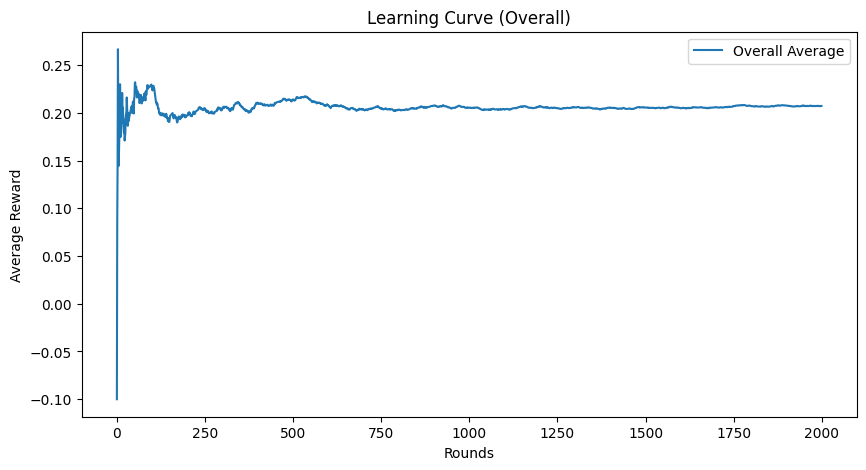

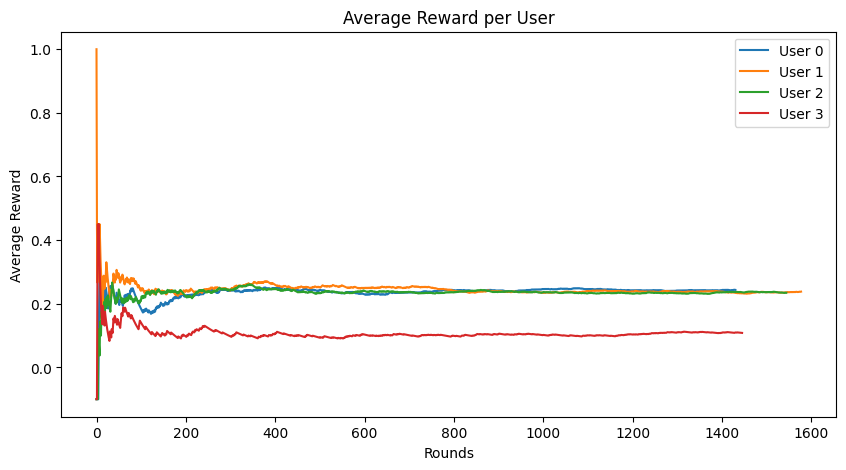

In [8]:
visualize_eGreedy(user_rewards_eGreedy, avg_rewards_eGreedy)

In [9]:
interactive_recommendation_eGreedy(agent_eGreedy)

Welcome to the Travel Recommender!

Gợi ý:
   1. Ha Long Bay (adventure)  |  score=0.245
   2. Phu Quoc (relaxation)  |  score=0.195
   3. Hanoi (culture)  |  score=0.183
Mô hình đã cập nhật phản hồi của bạn!

Gợi ý:
   1. Ha Long Bay (adventure)  |  score=0.245
   2. Phu Quoc (relaxation)  |  score=0.195
   3. Hanoi (culture)  |  score=0.183
Mô hình đã cập nhật phản hồi của bạn!

Gợi ý:
   1. Ha Long Bay (adventure)  |  score=0.245
   2. Phu Quoc (relaxation)  |  score=0.195
   3. Hanoi (culture)  |  score=0.183
Mô hình đã cập nhật phản hồi của bạn!

Gợi ý:
   1. Ha Long Bay (adventure)  |  score=0.246
   2. Phu Quoc (relaxation)  |  score=0.195
   3. Hanoi (culture)  |  score=0.183
Tạm biệt


## LinUCB

In [10]:
def context_to_vector(user):
    """
    Chuyển user prefs thành vector theo thứ tự place_types
    """
    return np.array([user["prefs"].get(ptype, 0) for ptype in place_types])

In [11]:
class LinUCBAgent:
    def __init__(self, n_arms, n_features, alpha=0.1):
        self.n_arms = n_arms
        self.n_features = n_features
        self.alpha = alpha  # độ tin cậy UCB
        self.A = [np.identity(n_features) for _ in range(n_arms)]
        self.b = [np.zeros(n_features) for _ in range(n_arms)]

    def select_arm(self, x):
        p = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[i])
            theta = A_inv @ self.b[i]
            p[i] = theta @ x + self.alpha * np.sqrt(x @ A_inv @ x)
        return np.argmax(p)

    def update(self, arm, x, reward):
        self.A[arm] += np.outer(x, x)
        self.b[arm] += reward * x

In [12]:
def simulate_training_per_user_LinUCB(agent, n_rounds=1000):
    user_rewards = {u["id"]: [] for u in user_profiles}
    avg_rewards = []
    arm_history = []

    for _ in range(n_rounds):
        user = random.choice(user_profiles)
        x = context_to_vector(user)

        # chọn top-3 gợi ý
        scores = []
        for arm in range(len(places)):
            A_inv = np.linalg.inv(agent.A[arm])
            theta = A_inv @ agent.b[arm]
            score = theta @ x + agent.alpha * np.sqrt(x @ A_inv @ x)
            scores.append(score)
        ranked = np.argsort(scores)[::-1][:3]

        for arm in ranked:
            reward = simulate_reward(user, places[arm])
            if reward == 1:
                pass
            else:
                reward = -0.1  # reward âm nếu không click
            agent.update(arm, x, reward)
            user_rewards[user["id"]].append(reward)
            arm_history.append(arm)

        avg_rewards.append(np.mean([r for lst in user_rewards.values() for r in lst]))

    print(f"✅ Offline training done! Avg reward: {np.mean(avg_rewards):.3f}")
    return agent, user_rewards, avg_rewards, arm_history

In [13]:
def visualize_LinUCB(user_rewards, avg_rewards):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(avg_rewards, label="Overall Average")
    plt.xlabel("Rounds"); plt.ylabel("Average Reward")
    plt.title("Learning Curve (Overall)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    for uid, rewards in user_rewards.items():
        if len(rewards) > 0:
            plt.plot(np.cumsum(rewards)/np.arange(1, len(rewards)+1), label=f"User {uid}")
    plt.xlabel("Rounds"); plt.ylabel("Average Reward")
    plt.title("Average Reward per User")
    plt.legend()
    plt.show()

In [14]:
def visualize_arm_distribution_LinUCB(agent, user_id=0):
    """
    Hiển thị score (dự đoán reward + confidence) của từng arm cho một user cụ thể
    """
    clear_output(wait=True)
    user = user_profiles[user_id]
    x = context_to_vector(user)

    scores = []
    for arm in range(agent.n_arms):
        A_inv = np.linalg.inv(agent.A[arm])
        theta = A_inv @ agent.b[arm]
        score = theta @ x + agent.alpha * np.sqrt(x @ A_inv @ x)
        scores.append(score)

    plt.figure(figsize=(10,6))
    sns.barplot(x=[p['name'] for p in places], y=scores, palette='viridis')
    plt.xticks(rotation=45)
    plt.ylabel("LinUCB Score (Reward + Confidence)")
    plt.xlabel("Places")
    plt.title(f"LinUCB Score per Arm for User {user_id}")
    plt.show()

In [15]:
def interactive_recommendation_LinUCB(agent):
    clear_output(wait=True)
    print("🌍 Welcome to the Travel Recommender (LinUCB)!")

    while True:
        user_input = input("Enter user id (0-3) or 'q' to quit: ")
        if user_input.lower() == 'q':
            print("Tạm biệt 👋")
            break

        try:
            user_id = int(user_input)
            if user_id < 0 or user_id >= len(user_profiles):
                print("User id không hợp lệ!")
                continue
        except:
            print("Nhập không hợp lệ!")
            continue

        user = user_profiles[user_id]
        x = context_to_vector(user)

        # Tính score cho từng place
        scores = []
        for arm in range(len(places)):
            A_inv = np.linalg.inv(agent.A[arm])
            theta = A_inv @ agent.b[arm]
            score = theta @ x + agent.alpha * np.sqrt(x @ A_inv @ x)
            scores.append(score)

        # Top-3 gợi ý
        ranked = np.argsort(scores)[::-1][:3]

        # Hiển thị gợi ý
        print(f"\nGợi ý dành cho User {user_id}:")
        for i, idx in enumerate(ranked):
            print(f"   {i+1}. {places[idx]['name']} ({places[idx]['type']})  |  score={scores[idx]:.3f}")

        # Nhập click
        clicks = input("\nBạn click gợi ý nào (vd: 1 3, hoặc 'q' để thoát): ")
        if clicks.lower() == 'q':
            print("Tạm biệt 👋")
            break

        clicked_arms = []
        for c in clicks.split():
            try:
                idx = int(c) - 1
                if idx >= 0 and idx < len(ranked):
                    clicked_arms.append(ranked[idx])
            except:
                continue

        # Cập nhật reward
        for arm in ranked:
            if arm in clicked_arms:
                try:
                    rating = float(input(f"Đánh giá {places[arm]['name']} (0-1): "))
                    rating = np.clip(rating, 0, 1)
                except:
                    rating = 1
                agent.update(arm, x, rating)
            else:
                agent.update(arm, x, -0.1)

        print("✅ Mô hình đã cập nhật phản hồi của bạn!")

In [16]:
agent_LinUCB = LinUCBAgent(n_arms=len(places), n_features=len(place_types), alpha=0.1)
agent_LinUCB, user_rewards_LinUCB, avg_rewards_LinUCB, arm_history_LinUCB = simulate_training_per_user_LinUCB(agent_LinUCB, n_rounds=2000)

✅ Offline training done! Avg reward: 0.323


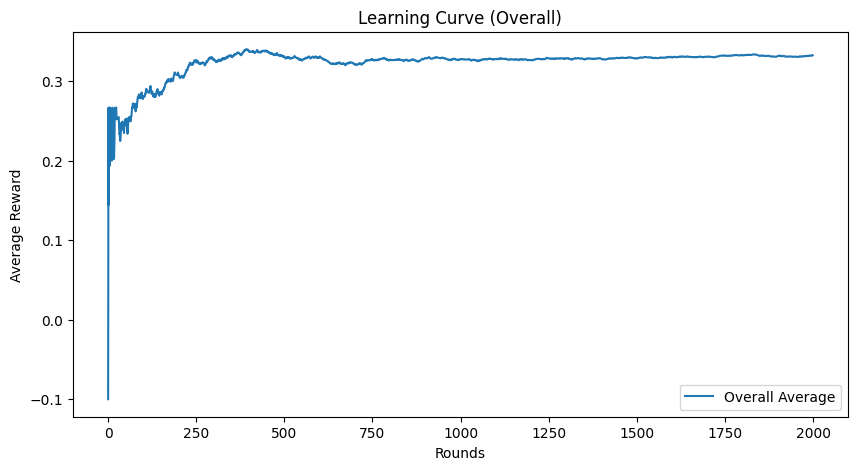

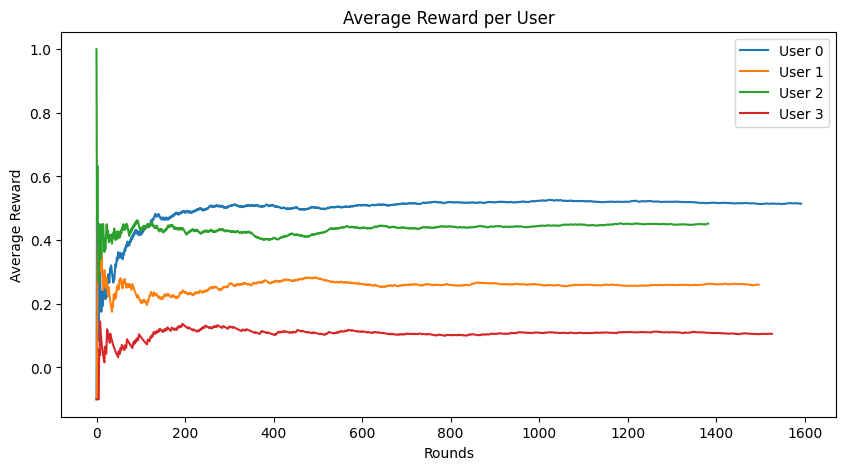

In [17]:
visualize_LinUCB(user_rewards_LinUCB, avg_rewards_LinUCB)

C:\Users\PC\AppData\Local\Temp\ipykernel_19452\936613402.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[p['name'] for p in places], y=scores, palette='viridis')


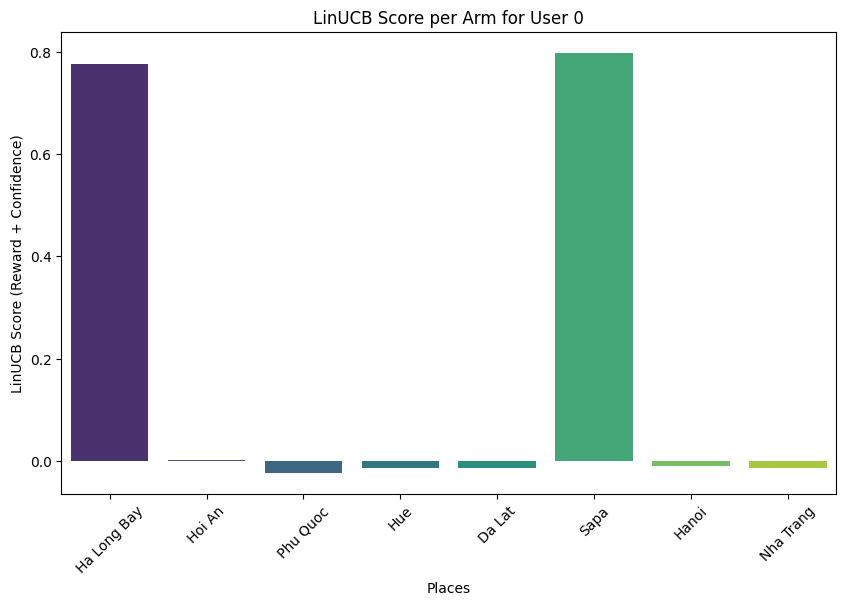

In [18]:
visualize_arm_distribution_LinUCB(agent_LinUCB, user_id=0)

In [19]:
interactive_recommendation_LinUCB(agent_LinUCB)

🌍 Welcome to the Travel Recommender (LinUCB)!
Tạm biệt 👋


## Thompson Sampling

In [19]:
class ContextualThompsonSampling:
    def __init__(self, n_arms, d, alpha=1.0):
        """
        n_arms: số lượng arm
        d: chiều dài vector context
        alpha: độ lệch chuẩn của prior
        """
        self.n_arms = n_arms
        self.d = d
        self.alpha = alpha

        # Mỗi arm có A, b (cho Bayesian linear regression)
        self.A = [np.identity(d) for _ in range(n_arms)]  # dxd
        self.b = [np.zeros(d) for _ in range(n_arms)]

    def select_arm(self, x):
        """Chọn arm tốt nhất dựa trên Thompson Sampling"""
        sampled_rewards = []
        for arm in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[arm])
            mu = A_inv @ self.b[arm]  # estimate weight vector
            cov = self.alpha**2 * A_inv
            theta_sample = np.random.multivariate_normal(mu, cov)
            reward_sample = x @ theta_sample
            sampled_rewards.append(reward_sample)
        return np.argmax(sampled_rewards)

    def update(self, arm, x, reward):
        """Cập nhật Bayesian posterior"""
        x = x.reshape(-1, 1)
        self.A[arm] += x @ x.T
        self.b[arm] += reward * x.flatten()

In [20]:
def simulate_training_per_user_TS(agent, n_rounds=1000):
    user_rewards = {u["id"]: [] for u in user_profiles}
    avg_rewards = []
    arm_history = []

    for _ in range(n_rounds):
        user = random.choice(user_profiles)
        x = context_to_vector(user)

        arm = agent.select_arm(x)
        reward = simulate_reward(user, places[arm])
        agent.update(arm, x, reward)

        user_rewards[user["id"]].append(reward)
        arm_history.append(arm)
        avg_rewards.append(np.mean([r for lst in user_rewards.values() for r in lst]))

    print(f"Offline training done! Avg reward: {np.mean(avg_rewards):.3f}")
    return agent, user_rewards, avg_rewards, arm_history

In [21]:
def visualize_TS(user_rewards, avg_rewards):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(avg_rewards, label="Overall Average")
    plt.xlabel("Rounds"); plt.ylabel("Average Reward")
    plt.title("Learning Curve (Overall)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    for uid, rewards in user_rewards.items():
        if len(rewards) > 0:
            plt.plot(np.cumsum(rewards)/np.arange(1, len(rewards)+1), label=f"User {uid}")
    plt.xlabel("Rounds"); plt.ylabel("Average Reward")
    plt.title("Average Reward per User")
    plt.legend()
    plt.show()

In [22]:
def visualize_arm_distribution(agent, user_id=0, n_samples=1000):
    clear_output(wait=True)
    user = user_profiles[user_id]
    x = context_to_vector(user)
    
    plt.figure(figsize=(10,6))
    for arm in range(agent.n_arms):
        A_inv = np.linalg.inv(agent.A[arm])
        mu = A_inv @ agent.b[arm]
        cov = agent.alpha**2 * A_inv
        theta_samples = np.random.multivariate_normal(mu, cov, size=n_samples)
        reward_samples = theta_samples @ x
        sns.kdeplot(reward_samples, label=f"{places[arm]['name']} ({places[arm]['type']})")
    
    plt.xlabel("Predicted Reward")
    plt.ylabel("Density")
    plt.title(f"Posterior Reward Distribution per Arm for User {user_id}")
    plt.legend()
    plt.show()

In [23]:
def interactive_recommendation_TS(agent):
    clear_output(wait=True)
    print("Welcome to the Travel Recommender (TS)!")
    
    while True:
        user_input = input("Enter user id (0-3) or 'q' to quit: ")
        if user_input.lower() == 'q':
            print("Tạm biệt")
            break

        try:
            user_id = int(user_input)
            if user_id < 0 or user_id >= len(user_profiles):
                print("User id không hợp lệ!")
                continue
        except:
            print("Nhập không hợp lệ!")
            continue

        user = user_profiles[user_id]
        x = context_to_vector(user)

        # Lấy top 3 gợi ý dùng Thompson Sampling
        ranked = []
        sampled_rewards = []
        for arm in range(agent.n_arms):
            A_inv = np.linalg.inv(agent.A[arm])
            mu = A_inv @ agent.b[arm]
            cov = agent.alpha**2 * A_inv
            theta_sample = np.random.multivariate_normal(mu, cov)
            sampled_rewards.append(x @ theta_sample)

        ranked = np.argsort(sampled_rewards)[::-1][:3]

        print("\nGợi ý:")
        for i, idx in enumerate(ranked):
            print(f"   {i+1}. {places[idx]['name']} ({places[idx]['type']})")

        clicks = input("\nClick vào gợi ý nào (vd: 1 2 3) hoặc 'q' để thoát: ")
        if clicks.lower() == 'q':
            print("Tạm biệt")
            break

        clicked_arms = []
        for c in clicks.split():
            try:
                idx = int(c) - 1
                if idx >= 0 and idx < len(ranked):
                    clicked_arms.append(ranked[idx])
            except:
                continue

        for arm in ranked:
            if arm in clicked_arms:
                try:
                    rating = float(input(f"Đánh giá {places[arm]['name']} (0-1): "))
                    rating = np.clip(rating, 0, 1)
                except:
                    rating = 1
                agent.update(arm, x, rating)
            else:
                agent.update(arm, x, 0)

        print("Mô hình đã cập nhật phản hồi của bạn!")

In [24]:
d = len(place_types)
agent_TS = ContextualThompsonSampling(n_arms=len(places), d=d, alpha=0.1)
agent_TS, user_rewards_TS, avg_rewards_TS, arm_history_TS = simulate_training_per_user_TS(agent_TS, n_rounds=2000)

Offline training done! Avg reward: 0.509


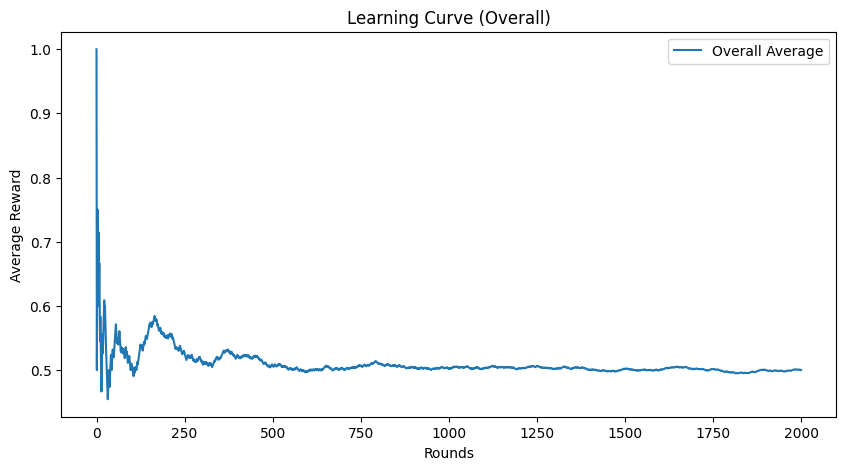

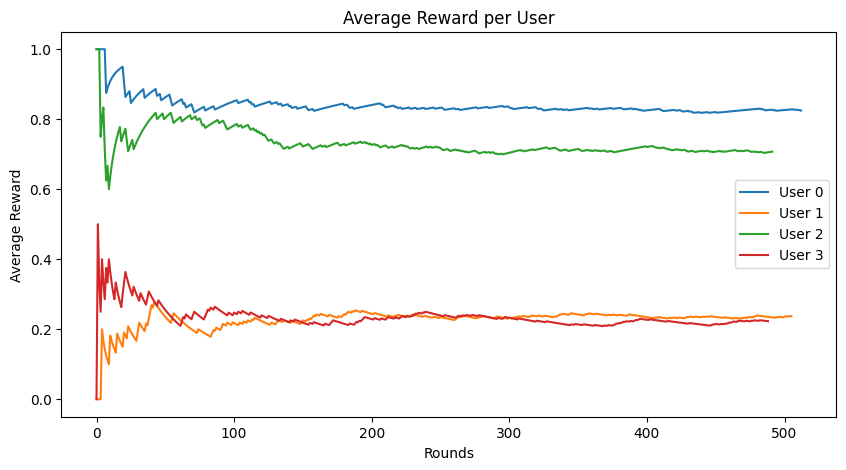

In [25]:
visualize_TS(user_rewards_TS, avg_rewards_TS)

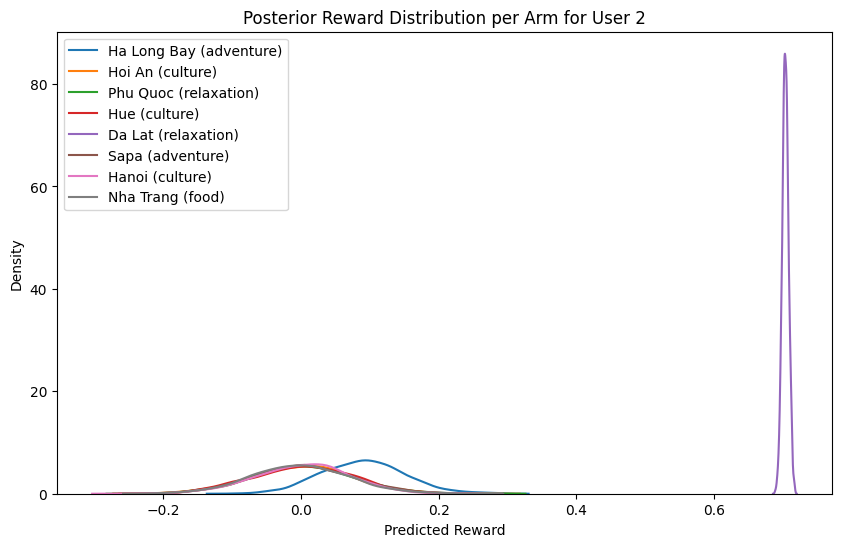

In [26]:
visualize_arm_distribution(agent_TS, user_id=2)

In [28]:
interactive_recommendation_TS(agent_TS)

Welcome to the Travel Recommender (TS)!
Tạm biệt
